# Imports

In [58]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


# Parameters for Strategy

In [59]:
ticker = 'NVDA'
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
momentum_window = 35 # number of days to measure momentum

# Fetch Data

In [60]:
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# Momentum Calculation

In [61]:
data['Momentum'] = data['Close'].diff(momentum_window)

# Create Trading Signals

In [62]:
# The idea is to map the momentum (+ or -) to 1 or -1, and use this to indicate a buy or sell
data['Signal'] = data['Momentum'].apply(lambda x: 1 if x > 0 else -1)

# Calculate Strategy Returns

In [63]:
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Strategy_Returns'] = data['Signal'].shift(1) * data['Log_Returns']
data['Cumulative_Strategy_Returns'] = data['Strategy_Returns'].cumsum().apply(np.exp)
    

# Charts

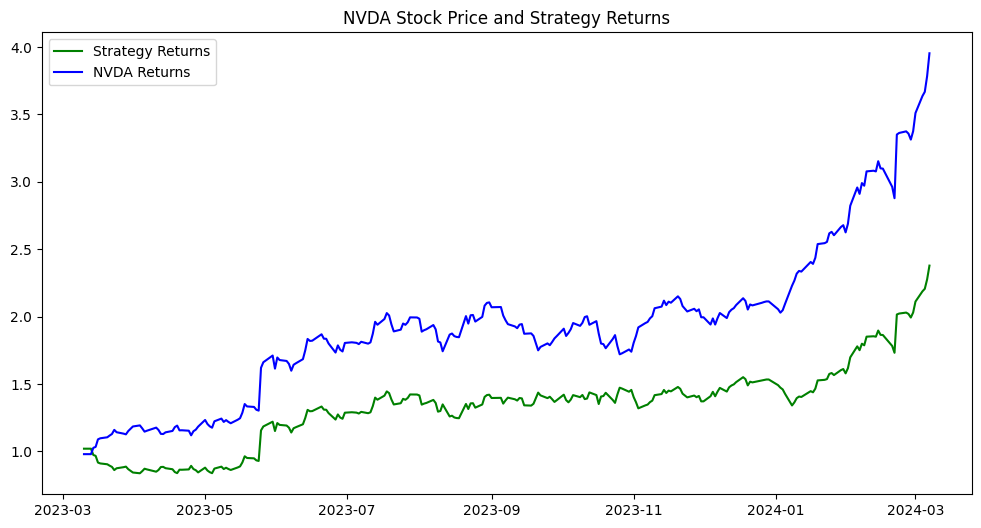

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Returns'], color='green', label='Strategy Returns')
plt.plot(np.exp(data['Log_Returns'].cumsum()), color='blue', label='NVDA Returns')
plt.title('NVDA Stock Price and Strategy Returns')
plt.legend()
plt.show()


# Additional Steps for Options Analysis
# Fetch NVDA ticker data from Yahoo Finance

In [67]:
nvda = yf.Ticker(ticker)

if data['Signal'].iloc[-1] > 0:  # Checking the latest signal
    print("Considering to buy calls based on positive momentum.")
    # Get options expirations
    options_expirations = nvda.options
    
      # For a strategy based on hype and recent sell-offs, consider an expiration
    # that gives the position more time to develop, e.g., the second or third available expiration date
    expiration = options_expirations[1]  # Adjust index as needed
    
    
    # Fetch options data for the chosen expiration
    options_chain = nvda.option_chain(expiration)
    calls = options_chain.calls
        
    suitable_calls = calls
   
   # Filtering logic for suitable calls:
    # 1. Slightly OTM: Current stock price < Strike Price <= Stock Price * 1.05
    # This captures calls that are up to 5% out-of-the-money.
    current_price = data['Close'].iloc[-1]
    suitable_calls = calls[(calls['strike'] > current_price) & (calls['strike'] <= current_price * 1.05)]
    
    # 2. Consider options with a higher open interest, indicating more liquidity.
    suitable_calls = suitable_calls.sort_values(by='openInterest', ascending=False).head(5)

    print(f"Suitable calls for expiration {expiration}:")
    print(suitable_calls)
else:
    print("No positive momentum, not considering buying calls at this time.")

Considering to buy calls based on positive momentum.
Suitable calls for expiration 2024-03-22:
          contractSymbol             lastTradeDate  strike  lastPrice    bid  \
109  NVDA240322C00950000 2024-03-08 20:59:57+00:00   950.0      26.15  25.45   
111  NVDA240322C00970000 2024-03-08 20:59:38+00:00   970.0      22.32  21.50   
107  NVDA240322C00930000 2024-03-08 20:59:50+00:00   930.0      31.00  30.25   
110  NVDA240322C00960000 2024-03-08 20:59:48+00:00   960.0      24.00  23.35   
108  NVDA240322C00940000 2024-03-08 20:59:36+00:00   940.0      28.60  27.70   

       ask     change  percentChange  volume  openInterest  impliedVolatility  \
109  26.35 -13.469999     -33.997980  6236.0        3638.0           0.778567   
111  22.40 -10.650002     -32.302097  2889.0        2692.0           0.796053   
107  31.20 -16.520000     -34.764310  1673.0        1114.0           0.762484   
110  24.25 -12.049999     -33.425797  2066.0         498.0           0.786715   
108  28.65 -14.9299